## Clustering neighbourhoods based on rental rates and venues

### Importing the necessary libraries

In [4]:
pip install BeautifulSoup4

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install geocoder

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [69]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import geocoder
from geopy.geocoders import Nominatim
import folium
import json
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

### Rental rates data from makaan.com

The website contains a list of all neighbourhoods in Bangalore city and their average rental rates. The data has been obtained by web scraping using the BeautifulSoup package in python

In [70]:
#Web scraping to get the data
dict_rent=[]

for page_no in range(1,20):
    url="https://www.makaan.com/price-trends/property-rates-for-rent-in-bangalore?page={}".format(str(page_no))
    source=requests.get(url).text
    soup=BeautifulSoup(source)
    table=soup.find('tbody')
    #print(table.prettify())
    rows=table.find_all('tr')
    for row in rows:
        region=row.find('td', class_="ta-l link-td-txt").text.strip()
        bhk_1 = row.find_all('td',class_="caps ta-c")[0].text.strip()
        bhk_2 = row.find_all('td',class_="caps ta-c")[1].text.strip()
        bhk_3 = row.find_all('td',class_="caps ta-c")[2].text.strip()
        dict_rent.append([region,bhk_1,bhk_2,bhk_3])
    
#print(dict_rent)


In [71]:
#Converting to dataframe
rent_data=pd.DataFrame(dict_rent,columns=['Neighborhood','1_bhk','2_bhk','3_bhk'])
rent_data

,Neighborhood,1_bhk,2_bhk,3_bhk
0,HSR Layout,"16,256.02","26,750","54,818.18"
1,Koramangala,"18,732.43","32,327.27","57,31.25"
2,Jigani,"20,750","7,000","15,312.5"
3,Mahadevapura,"10,328.57","13,525","35,000"
4,Whitefield Hope Farm Junction,"5,000","13,500","96,400"
...,...,...,...,...
1135,horamavu kalyan nagar,-,-,-
1136,Hosakerehalli Main Road,-,-,"20,000"
1137,Hosur Malur Road NH 207,-,-,-
1138,hsr,-,-,-


### Data cleansing
NaN values are stored as '-' and may pose errors later on. First we replace these by NaN objects. Next, we remove duplicate neighborhoods. Finally, the rents are all stored as string characters and need to be converted into float.

In [72]:
rent_data.replace(to_replace='-',value=np.nan, inplace=True, regex=True)
rent_data.dropna(axis=0,inplace=True)
rent_data.drop_duplicates(subset=['Neighborhood'],keep='first',inplace=True)

rent_data['1_bhk']=[float(i.replace(',','')) for i in rent_data['1_bhk']]
rent_data['2_bhk']=[float(i.replace(',','')) for i in rent_data['2_bhk']]
rent_data['3_bhk']=[float(i.replace(',','')) for i in rent_data['3_bhk']]
rent_data

,Neighborhood,1_bhk,2_bhk,3_bhk
0,HSR Layout,16256.02,26750.00,54818.18
1,Koramangala,18732.43,32327.27,5731.25
2,Jigani,20750.00,7000.00,15312.50
3,Mahadevapura,10328.57,13525.00,35000.00
4,Whitefield Hope Farm Junction,5000.00,13500.00,96400.00
...,...,...,...,...
999,Devanachicknhalli,6000.00,10500.00,26000.00
1012,Hoodi ITPL Road Mahadevapura,14000.00,21000.00,38000.00
1054,Shri Krishna Nagar 8th Phase,6000.00,20000.00,18000.00
1079,Ajjanahalli,20000.00,30000.00,29000.00


### Latitude longitude information from Kaggle

Since the data obtained above has no information related to latitude and longitude, we have to obtain that from some other source. A little exploration on Kaggle gives us a well structured dataset by Rahul Menon. This dataset has been downloaded and read into a dataframe in the next steps. 

In [73]:
coords=pd.read_csv('blr_neighborhoods.csv')
coords.drop('Unnamed: 0',inplace=True,axis=1)
coords.drop_duplicates(inplace=True,keep='first',subset=['Neighborhood'])
print(coords.tail(20))

                   Neighborhood   Latitude  Longitude
331                     Sulleri  12.575591  77.172696
332           Syakaladevanapura  13.246901  77.428881
333                 Tagachagere  12.629340  77.231089
334                   Tattekere  12.672868  77.573794
336  Tavarekere S.O (Bangalore)  12.963694  77.401424
337                Thimmasandra  13.123888  77.773316
338                Thippasandra  12.973936  77.650998
339                     Tungani  -4.379614 -79.464359
340                 Tyamagondlu  13.214631  77.300428
341                    Udukunte  13.131771  77.235297
342                   Uganavadi  13.236588  77.665414
343               Vanakanahalli  12.672071  77.694284
344                   Veerapura  13.391123  77.886618
345             Venkatagirikote  13.327401  77.733614
346                 Vidyanagara  13.018496  76.108893
347              Virupakshipura  13.024075  76.469658
348             Vishwanathapura  13.273529  77.649099
349             Yadamaranaha

## Data cleansing

On having a quick glance at the data we see that some of the longitudes are negative while some are positive. Also, there are some neighbourhoods with a very different latitude/longitude value that is definitely not within the geographical stretch of Bangalore. 
So let's explore and fix these outliers.

In [74]:
coords['Longitude']=[i if i>0 else -i for i in coords['Longitude'] ]

Also let's remove all the occurances of S.O. (Bangalore) because it'll be difficult to match it with our Makaan dataset


In [75]:
SO_list=["S.O" in i for i in coords['Neighborhood']]
#print(SO_list)
SO_list=coords[SO_list]
SO_list

,Neighborhood,Latitude,Longitude
19,Indiranagar S.O (Bangalore),12.973291,77.640467
53,Bommanahalli S.O (Bangalore),13.345732,77.433335
60,Girinagar S.O (Bangalore),12.940144,77.544500
110,Nagasandra S.O (Bangalore),13.047950,77.500135
118,Vijayanagar S.O (Bangalore),12.971889,77.545789
141,Bagalur S.O (Bangalore),13.133187,77.668709
336,Tavarekere S.O (Bangalore),12.963694,77.401424


In [76]:
coords['Neighborhood']=[i.replace(' S.O (Bangalore)','') for i in coords['Neighborhood']]

Similarly, we don't need "H.O"

In [77]:
HO_list=["H.O" in i for i in coords['Neighborhood']]
HO_list=coords[HO_list]
HO_list

,Neighborhood,Latitude,Longitude
50,Basavanagudi H.O,13.834591,75.733936
68,Jayanagar H.O,12.929273,77.582423
100,Jalahalli H.O,13.046453,77.548380
112,Rajajinagar H.O,15.415452,75.044062


In [78]:
coords['Neighborhood']=[i.replace(' H.O','') for i in coords['Neighborhood']]

Now let's have a look at the outliers. Any latitude-longitude data that lies outside the 11 to 14 degrees North and -75 to -79 degrees East range.

In [79]:
outliers=coords[((coords['Latitude']>14)| (coords['Latitude']<11))|((coords['Longitude']>77.9)|(coords['Longitude']<77.1))]
#outliers

Let's check which of these are present in the rentals data:

In [80]:
outlier_merge=pd.merge(outliers,rent_data,on='Neighborhood')
outlier_merge

,Neighborhood,Latitude,Longitude,1_bhk,2_bhk,3_bhk
0,Bellandur,58.235358,26.683116,20687.50,22000.00,34000.00
1,Mahadevapura,14.466722,76.574523,10328.57,13525.00,35000.00
2,Whitefield,44.373441,71.610260,15697.38,18845.15,37900.00
3,Banashankari,15.887678,75.704678,1231.25,18227.27,27833.33
4,Basavanagudi,13.834591,75.733936,866.67,18000.00,29000.00
5,Begur,52.480709,13.451829,7875.00,10875.00,25000.00
6,Chandapura,17.443639,77.433391,9000.00,14000.00,13000.00
7,Hulimavu,12.159799,76.733290,10800.00,13500.00,22750.00
8,Malleswaram,16.355021,81.267918,6500.00,30000.00,35000.00
9,Rajajinagar,15.415452,75.044062,28500.00,23875.00,40000.00


Let's fix the latitudes and longitudes of only these neighbourhoods.I have obtained the data for the above 12 regions from google. <br/>Interesting note: Turns out that the outliers are real i.e. such regions (with the exact same names) do exist but they are not a part of Bangalore.



In [81]:
#List of new coordinates
updated_coords=[('Bellandur', 12.9304,77.6784),
                ('Mahadevapura',12.9880,77.6895),
                ('Whitefield',12.9698,77.7500),
                ('Banashankari',12.9255,77.5468),
                ('Basavanagudi', 12.9406, 77.5738),
                ('Hulimavu',12.8791,77.6098),
                ('Begur',12.8788,77.6377),
                ('Chandapura',12.8017,77.7116),
                ('Malleswaram',13.0055,77.5692),
                ('Rajajinagar',12.9982,77.5530),
               ('Kodihalli',12.9654,77.6493),
               ('Nagavara',13.0422,77.6136)]
#Updating original data
for item in updated_coords:
    #print(item[0])
    coords.loc[coords['Neighborhood']==item[0],['Latitude']]=item[1]
    coords.loc[coords['Neighborhood']==item[0],['Longitude']]=item[2]
coords

,Neighborhood,Latitude,Longitude
0,Agram,45.813177,15.977048
1,Amruthahalli,13.066513,77.596624
2,Attur,11.663711,78.533551
3,Banaswadi,13.014162,77.651854
4,Bellandur,12.930400,77.678400
...,...,...,...
347,Virupakshipura,13.024075,76.469658
348,Vishwanathapura,13.273529,77.649099
349,Yadamaranahalli,12.427249,77.379083
350,Yadavanahalli,12.789855,77.751454


### Combining coordinates and rental rates data


In [82]:
df= pd.merge(rent_data,coords,on='Neighborhood')

### Calculate average price of a single room (1/2/3 bhk)

In [83]:
df['avg_rent']=((df['1_bhk']+(df['2_bhk']/2)+(df['3_bhk']/3))/3)
df.avg_rent = df.avg_rent.astype(float)

Now to include the prices as a metric for our clustering, let's assign a rent bucket to each price range.<br/><br/> I have assigned a flag to each neighborhood based on the average rent. <br/>If the rent is less than 8000Rs, it is being flagged as "Low". For those below 10000Rs, I have marked them as "Medium" and those above 10000Rs are marked as "High".

In [84]:
bucket=[]
for i in df['avg_rent']:
    if float(i)<8000:
        rentometer='Low'
    elif float(i)<10000:
        rentometer='Medium'
    else:
        rentometer='High'
    bucket.append(rentometer)
df['Rent_bucket']=bucket
df.head(50)

,Neighborhood,1_bhk,2_bhk,3_bhk,Latitude,Longitude,avg_rent,Rent_bucket
0,Koramangala,18732.43,32327.27,5731.25,12.934011,77.622230,12268.827222,High
1,Jigani,20750.00,7000.00,15312.50,12.785253,77.638093,9784.722222,Medium
2,Mahadevapura,10328.57,13525.00,35000.00,12.988000,77.689500,9585.912222,Medium
3,Whitefield,15697.38,18845.15,37900.00,12.969800,77.750000,12584.429444,High
4,Yelahanka,6625.00,10000.00,32459.78,13.100698,77.596345,7481.642222,Low
5,Devanahalli,15000.00,16000.00,51666.67,13.248350,77.713438,13407.407778,High
6,Jakkur,14214.29,19142.86,43000.00,13.078474,77.606894,12706.351111,High
7,Chandapura,9000.00,14000.00,13000.00,12.801700,77.711600,6777.777778,Low
8,Horamavu,11200.00,17165.00,22333.33,13.027331,77.660151,9075.647778,Medium
9,Bellandur,20687.50,22000.00,34000.00,12.930400,77.678400,14340.277778,High


## Exploratory Data Analysis


Now let's explore the rental rates for different types of apartments in Bangalore.We can plot boxplots for the three kinds (1bhk, 2bhk and 3bhk) to see how much it would cost for a person trying to rent a single room. For that the rent of 2bhks and 3bhks will be divided by 2 and 3 repectively.


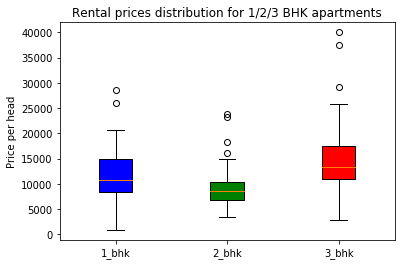

In [85]:
eda_1=df
eda_1['RentPerRoom_2bhk']=eda_1['2_bhk']/2
eda_1['RentPerRoom_3bhk']=eda_1['3_bhk']/2
eda_1.rename(columns={'1_bhk':'RentPerRoom_1bhk'}, inplace=True)

box=plt.boxplot([eda_1['RentPerRoom_1bhk'],eda_1['RentPerRoom_2bhk'],eda_1['RentPerRoom_3bhk']],
                labels=['1_bhk','2_bhk','3_bhk'],
                patch_artist=True,
               )

plt.title("Rental prices distribution for 1/2/3 BHK apartments")
plt.ylabel("Price per head")

colors = ['blue', 'green','red']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

<b> Observation</b><br/>The prices for 1BHK flats lie in the range of 8k to 15k. While those for the 2BHKs have a lower range of about 6.5k to 10k. The 3BHK flats are the costly ones with prices ranging from 11k to 16k per head. 

Let us check how many of the regions have high, low and medium rental rates in Banaglore.

In [86]:
x=blr_venues['Venue Category'].
plt.bar()

SyntaxError: invalid syntax (<ipython-input-86-b59f8d272955>, line 1)

In [ ]:
x=np.array(df['Rent_bucket'])
unique_elements, counts_elements = np.unique(x, return_counts=True)
#print(type(unique_elements))

count_bucket=pd.DataFrame([i for i in zip(unique_elements,counts_elements)],columns=['Rent','Count'])
count_bucket
plt.bar(count_bucket['Rent'],count_bucket['Count'])
plt.yticks(range(0,20,5))
plt.ylabel('Count of Neighborhoods')
plt.title("Number of regions based on rental rates")
plt.show()

<b>Observation</b><br/>The number of regions having low to medium rental rates are almost equal. But the regions having high rental rates surpass them. This observation is in agreement with the fact that Banaglore is an expensive city.

### One hot encoding<br/>
Now let's encode these rent buckets by the one hot encoding scheme so that we can include them in our clustering. This will help us combine both the datasets because as we will see later, we shall encode the different venues too.

In [96]:
rent_onehot = pd.get_dummies(df[['Rent_bucket']], prefix="", prefix_sep="")

# add Neighbourhood column back to dataframe
rent_onehot['Neighborhood'] = df['Neighborhood'] 

# move Neighbourhood column to the first column
fixed_columns = [rent_onehot.columns[-1]] + list(rent_onehot.columns[:-1])
rent_onehot = rent_onehot[fixed_columns]

#rent_onehot

## Foursquare data

Now that we have obtained the rental rates in different regions along with their exact latitudes and longitude, we can go ahead and explore each region. We shall do this with the help of the Foursquare API. 

In [ ]:
### Getting foursquare data in each neigghbourhood
CLIENT_ID = 'Y35CVUCI4ZFRNXVDG5RUGZETIMA3ZHJFRQUIGDN3AUA50KA3' # your Foursquare ID
CLIENT_SECRET = 'JICEJHLA52T1U22GW41OJGH4VLWKABF4U2CAR24G5PIQUKYP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

The following function will get all the venues (max. 100 venues) within a radius of 500m from the center of the neighborhood.The function has been called for ecah of the neighborhoods present in the rent_data set

In [ ]:
def getNearbyVenues(name, lat, lng, radius=500):
        # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
    l=[(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results]
    return l

In [87]:
LIMIT = 100 
radius = 500
venues_list=[]
for i in range(len(df)) : 
    #print(df.loc[i, 'Neighborhood'], df.loc[i, 'Latitude'],df.loc[i,'Longitude']) 
    #print(item)
    print(df.loc[i, 'Neighborhood'])
    venues_list.append(getNearbyVenues(df.loc[i, 'Neighborhood'],
                                   df.loc[i, 'Latitude'],
                                   df.loc[i,'Longitude']
                                  ))
#print(venues_list)
nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues.columns = ['Neighborhood','Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
nearby_venues

Koramangala
Jigani
Mahadevapura
Whitefield
Yelahanka
Devanahalli
Jakkur
Chandapura
Horamavu
Bellandur
Banashankari
Begur
Banaswadi
Hoskote
Nagarbhavi
Kadugodi
Kengeri
Subramanyapura
Bommanahalli
Attibele
Gottigere
Rajajinagar
Jalahalli
Vidyaranyapura
Konanakunte
Hulimavu
Kannamangala
Hoodi
Chikkalasandra
Narayanapura
Jayanagar
Nagavara
Kodigehalli
Singasandra
Basavanagudi
Panathur
Malleswaram
Lingarajapuram
Vijayanagar
Adugodi
Kothanur
Mallathahalli
Yelachenahalli
Domlur
Kodihalli
Kathriguppe
Indiranagar


,Neighborhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Koramangala,12.934011,77.622230,Chianti,12.933537,77.621862,Italian Restaurant
1,Koramangala,12.934011,77.622230,a 1oōo yoga,12.933552,77.621766,Yoga Studio
2,Koramangala,12.934011,77.622230,Cafe D'hide,12.933575,77.622442,Café
3,Koramangala,12.934011,77.622230,Kargeens,12.935271,77.624175,Café
4,Koramangala,12.934011,77.622230,Nagarjuna,12.933693,77.621156,Andhra Restaurant
...,...,...,...,...,...,...,...
404,Indiranagar,12.973291,77.640467,High Note Bar and Dining,12.968883,77.641163,Diner
405,Indiranagar,12.973291,77.640467,Chili's Grill & Bar,12.969237,77.641414,Tex-Mex Restaurant
406,Indiranagar,12.973291,77.640467,Esplanade,12.969199,77.641473,Indian Restaurant
407,Indiranagar,12.973291,77.640467,Terrazzo,12.969337,77.641404,Italian Restaurant


We see that the function has successfully returned the venues in each region. Upon quick glance, Bangalore seems to be a place filled with restaurants and cafes.

<b> Backup</b>
<br/> Because the no. of calls are limited per day, let's save all the foursquare data in a csv for good measure.

In [88]:
nearby_venues.to_csv('Foursquare_backup.csv',index=False)

In [89]:
blr_venues=nearby_venues.copy()

In [90]:
print(blr_venues['Venue Category'].unique())

['Italian Restaurant' 'Yoga Studio' 'Café' 'Andhra Restaurant' 'Gym'
 'Candy Store' 'Thai Restaurant' 'Breakfast Spot' 'Fast Food Restaurant'
 'Bar' 'Coffee Shop' 'Chinese Restaurant' 'Indian Restaurant' 'Pub'
 'Mobile Phone Shop' 'Indian Sweet Shop' 'Dessert Shop' 'Ice Cream Shop'
 'Lounge' 'Kerala Restaurant' 'Seafood Restaurant' 'Liquor Store'
 'Mexican Restaurant' 'South Indian Restaurant' 'BBQ Joint' 'Brewery'
 'Gastropub' 'American Restaurant' 'Park' 'Snack Place' 'Asian Restaurant'
 'Bengali Restaurant' 'Paper / Office Supplies Store'
 'Vegetarian / Vegan Restaurant' 'Jewelry Store' 'Bistro'
 'Department Store' 'Hotel' 'Juice Bar' 'Southern / Soul Food Restaurant'
 'Bus Station' 'Eastern European Restaurant' 'Gym / Fitness Center'
 'Bakery' 'Hotel Bar' 'Diner' 'Market' 'ATM' 'Train Station' 'Campground'
 'Dry Cleaner' 'Athletics & Sports' 'Soccer Field' 'Shopping Mall'
 'Pizza Place' 'Clothing Store' 'North Indian Restaurant'
 'Sporting Goods Shop' 'Accessories Store' 'Shoe Stor

### Top 5 cateories of venues in Bangalore

Text(0.5, 1.0, 'Top 5 venue types in Bangalore')

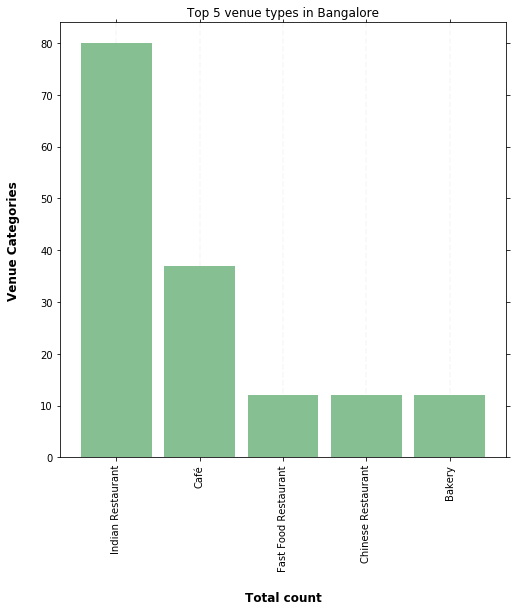

In [91]:
x=np.array(blr_venues['Venue Category'])
unique_elements, counts_elements = np.unique(x, return_counts=True)
#print(unique_elements)


count_bucket=pd.DataFrame([i for i in zip(unique_elements,counts_elements)],columns=['Category','Count'])
count_bucket.set_index('Category',inplace=True)
count_bucket=count_bucket['Count'].sort_values(ascending=False).head(5)

#count_bucket.plot(kind='barh')
ax = count_bucket.plot(kind='bar', figsize=(8,8), color='#86bf91', zorder=2, width=0.85)


# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set x-axis label
ax.set_xlabel("Total count", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Venue Categories", labelpad=20, weight='bold', size=12)

ax.set_title("Top 5 venue types in Bangalore")

## Relation between venues and rental rates


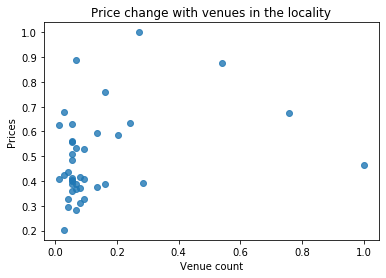

In [92]:
venue_eatery=blr_venues.groupby('Neighborhood')['Venue Category'].count().to_frame().rename(columns={'Venue Category':'Total_Numbers'}).reset_index()
venue_eatery=venue_eatery.merge(rent_data,on='Neighborhood')
x=venue_eatery['Total_Numbers']/max(venue_eatery['Total_Numbers'])
y=(venue_eatery['1_bhk']+venue_eatery['2_bhk']+venue_eatery['3_bhk'])/6
y=y/max(y)

#Plot
sns.regplot(x, y, fit_reg=False)
#plt.scatter(x,y/max(y), alpha=0.5, color='b',edgecolors='r')
plt.title('Price change with venues in the locality')
plt.xlabel('Venue count')
plt.ylabel('Prices')
#plt.xlim(0,0.25)
plt.show()

<b> Obseravtion</b><br/>
There is not much relation between the number of venues in a locality and the rental rates of the locality.This can be due to several factors:
<ul><li>FourSquare does not have information about all the venues in a particular area.</li><li>The rental rates are dependent on more factors like transportation, demographics of the region, how old that part of Bangalore is, etc.</li><li>The radius for API calls is too small to include proper data.</li></ul>

In [97]:
# one hot encoding
blr_onehot = pd.get_dummies(blr_venues[['Venue Category']], prefix="", prefix_sep="")

# add Neighbourhood column back to dataframe
blr_onehot['Neighborhood'] = blr_venues['Neighborhood'] 

# move Neighbourhood column to the first column
fixed_columns = [blr_onehot.columns[-1]] + list(blr_onehot.columns[:-1])
blr_onehot = blr_onehot[fixed_columns]

#blr_onehot.head()

In [98]:
one_hot= pd.merge(blr_onehot,rent_onehot, on='Neighborhood')
#one_hot

In [99]:
blr_grouped = one_hot.groupby('Neighborhood').mean().reset_index()
#blr_grouped

### Most common venues in each area

Although there wasn't a relation between the rental rates and number of venues, we can check what was the most commonly occuring venue in each neighborhood.

In [125]:
num_top_venues = 4
top_3_venues={}
for hood in blr_grouped['Neighborhood']:
    #print("----"+hood+"----")
    temp = blr_grouped[blr_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2}).sort_values('freq',ascending=False).head(4)
    key=hood
    drop_item=['High','Low','Medium']
    value=[i for i in temp['venue'] if i not in drop_item]
    top_3_venues[key]=value
    #print(temp['venue'])
    #top_3_venues.append((temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)))

top_venues_df=pd.DataFrame(top_3_venues)
top_venues_df=top_venues_df.T.reset_index()
top_venues_df.columns=['Neighbourhood','1st most common venue','2nd most common venue','3rd most common venue']
top_venues_df

,Neighbourhood,1st most common venue,2nd most common venue,3rd most common venue
0,Adugodi,Athletics & Sports,Ice Cream Shop,Playground
1,Attibele,Indian Restaurant,South Indian Restaurant,ATM
2,Banashankari,Indian Restaurant,Clothing Store,Café
3,Banaswadi,Vegetarian / Vegan Restaurant,Indian Restaurant,Pharmacy
4,Basavanagudi,Indian Restaurant,Café,Fast Food Restaurant
5,Begur,Mobile Phone Shop,Clothing Store,Bakery
6,Bellandur,Indian Restaurant,Shopping Mall,Soccer Field
7,Chandapura,Indian Restaurant,Department Store,Dry Cleaner
8,Chikkalasandra,Indian Restaurant,Department Store,Bakery
9,Devanahalli,ATM,Campground,Motorcycle Shop


The rental rates and the venues data will now be leveraged to visualize the clusters.

### Clustering

The aim of this project is to help clients choose an appropriate neighborhood based on the rental rates and how busy the area is. Most people would prefer to stay at locations which have a lot of restaurants and cafes nearby while also minimizing the rent that they have to pay. So we will craete clusters based on the rent and the venues and visualize the result on Folium maps.

In [93]:
# set number of clusters
kclusters = 4

blr_grouped_clustering = blr_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(blr_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


array([0, 1, 1, 0, 1, 1, 0, 1, 2, 3], dtype=int32)

In [94]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]


In [95]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = blr_grouped['Neighborhood']

for ind in np.arange(blr_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(blr_grouped.iloc[ind, :], num_top_venues)



In [96]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

blr_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
blr_merged = blr_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


In [97]:
blr_merged.drop(['2_bhk','3_bhk'],inplace=True, axis=1) 
blr_merged.dropna(subset=['Cluster Labels'],inplace=True,axis=0)

In [98]:
#changing to meaningful cluster labels
blr_merged['Cluster Labels']=[int(i) for i in blr_merged['Cluster Labels']]
#blr_merged

### Examine clusters

In [99]:
blr_merged.loc[blr_merged['Cluster Labels'] == 0]

,Neighborhood,RentPerRoom_1bhk,Latitude,Longitude,avg_rent,Rent_bucket,RentPerRoom_2bhk,RentPerRoom_3bhk,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Koramangala,18732.43,12.934011,77.622230,12268.827222,High,16163.635,2865.625,0,High,Indian Restaurant,Café,Coffee Shop,Pub,Italian Restaurant,Lounge,Ice Cream Shop,Breakfast Spot,Snack Place
3,Whitefield,15697.38,12.969800,77.750000,12584.429444,High,9422.575,18950.000,0,High,Hotel Bar,Gym / Fitness Center,Diner,Market,Café,Bakery,Kerala Restaurant,Ice Cream Shop,Hotel
9,Bellandur,20687.50,12.930400,77.678400,14340.277778,High,11000.000,17000.000,0,High,Indian Restaurant,Soccer Field,Shopping Mall,Fast Food Restaurant,Hookah Bar,Health & Beauty Service,Coffee Shop,Convenience Store,Cupcake Shop
12,Banaswadi,16120.69,13.014162,77.651854,11945.946667,High,10666.040,13576.665,0,High,Indian Restaurant,Vegetarian / Vegan Restaurant,Pharmacy,Kerala Restaurant,BBQ Joint,Eastern European Restaurant,Convenience Store,Cupcake Shop,Deli / Bodega
14,Nagarbhavi,10837.50,12.965101,77.507863,10495.833333,High,10750.000,14850.000,0,High,Café,Indian Restaurant,Market,Medium,Eastern European Restaurant,Convenience Store,Cupcake Shop,Deli / Bodega,Department Store
15,Kadugodi,16761.54,13.021626,77.766180,12170.513889,High,8083.335,17500.000,0,High,Indian Sweet Shop,Coffee Shop,Gym,Bakery,Eastern European Restaurant,Convenience Store,Cupcake Shop,Deli / Bodega,Department Store
21,Rajajinagar,28500.00,12.998200,77.553000,17923.611111,High,11937.500,20000.000,0,High,Indian Restaurant,Café,Vegetarian / Vegan Restaurant,Gym,Fast Food Restaurant,Lounge,Light Rail Station,Coffee Shop,Grocery Store
24,Konanakunte,13500.00,12.886018,77.579141,11554.486667,High,8625.000,18807.690,0,High,Indian Restaurant,Café,Dumpling Restaurant,Breakfast Spot,Medium,Eastern European Restaurant,Convenience Store,Cupcake Shop,Deli / Bodega
30,Jayanagar,11000.00,12.929273,77.582423,14194.444444,High,23750.000,11750.000,0,High,Indian Restaurant,Café,Juice Bar,Chinese Restaurant,Fast Food Restaurant,Sandwich Place,Restaurant,Snack Place,Shopping Plaza
35,Panathur,16500.00,12.935146,77.704754,11802.777778,High,8375.000,15800.000,0,High,Train Station,Department Store,Sports Club,Supermarket,Dry Cleaner,Donut Shop,Diner,Dessert Shop,Medium


In [101]:
blr_merged.loc[blr_merged['Cluster Labels'] == 1]
##Low rent stores and local restaurants

,Neighborhood,RentPerRoom_1bhk,Latitude,Longitude,avg_rent,Rent_bucket,RentPerRoom_2bhk,RentPerRoom_3bhk,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Yelahanka,6625.00,13.100698,77.596345,7481.642222,Low,5000.000,16229.890,1,Low,ATM,Department Store,Train Station,Accessories Store,Flea Market,Convenience Store,Cupcake Shop,Deli / Bodega,Dessert Shop
7,Chandapura,9000.00,12.801700,77.711600,6777.777778,Low,7000.000,6500.000,1,Low,Indian Restaurant,Department Store,Dry Cleaner,Fast Food Restaurant,Coffee Shop,Convenience Store,Cupcake Shop,Deli / Bodega,Dessert Shop
10,Banashankari,1231.25,12.925500,77.546800,6540.887222,Low,9113.635,13916.665,1,Low,Clothing Store,Indian Restaurant,Café,Sporting Goods Shop,Fast Food Restaurant,North Indian Restaurant,Shoe Store,Pizza Place,Accessories Store
11,Begur,7875.00,12.878800,77.637700,7215.277778,Low,5437.500,12500.000,1,Low,Bakery,Mobile Phone Shop,Supermarket,Clothing Store,Health & Beauty Service,Gym / Fitness Center,Coffee Shop,Convenience Store,Cupcake Shop
16,Kengeri,10375.00,12.917657,77.483757,6833.333333,Low,6125.000,6000.000,1,Low,Ice Cream Shop,Pizza Place,Pharmacy,Train Station,Café,Dumpling Restaurant,Convenience Store,Cupcake Shop,Deli / Bodega
17,Subramanyapura,5500.00,12.883971,77.541211,6248.365556,Low,5500.000,11617.645,1,Low,Indian Restaurant,Cantonese Restaurant,Ice Cream Shop,Hotel Bar,Coffee Shop,Convenience Store,Cupcake Shop,Deli / Bodega,Department Store
19,Attibele,5000.00,12.778259,77.771283,4250.000000,Low,3500.000,6375.000,1,Low,South Indian Restaurant,Indian Restaurant,Hotel Bar,Dumpling Restaurant,Coffee Shop,Convenience Store,Cupcake Shop,Deli / Bodega,Department Store
20,Gottigere,938.24,12.856532,77.587724,5034.968889,Low,5500.000,13000.000,1,Low,Indian Restaurant,Department Store,Grocery Store,Dessert Shop,Bus Stop,Ice Cream Shop,Dumpling Restaurant,Coffee Shop,Convenience Store
22,Jalahalli,6166.67,13.046453,77.548380,7708.813333,Low,8500.000,12689.655,1,Low,Indian Restaurant,Vegetarian / Vegan Restaurant,Shopping Mall,Fast Food Restaurant,Eastern European Restaurant,Coffee Shop,Convenience Store,Cupcake Shop,Deli / Bodega
31,Nagavara,8333.33,13.042200,77.613600,7027.776667,Low,6750.000,9000.000,1,Low,Hotel,Indian Restaurant,Lake,Bus Station,Buffet,Eastern European Restaurant,Cupcake Shop,Deli / Bodega,Department Store


In [102]:
blr_merged.loc[blr_merged['Cluster Labels'] == 2]
#Medium rent all kinds of stores

,Neighborhood,RentPerRoom_1bhk,Latitude,Longitude,avg_rent,Rent_bucket,RentPerRoom_2bhk,RentPerRoom_3bhk,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Mahadevapura,10328.57,12.988000,77.689500,9585.912222,Medium,6762.50,17500.000,2,Medium,Southern / Soul Food Restaurant,Department Store,Bus Station,Indian Restaurant,Health & Beauty Service,Hookah Bar,Coffee Shop,Convenience Store,Cupcake Shop
8,Horamavu,11200.00,13.027331,77.660151,9075.647778,Medium,8582.50,11166.665,2,Medium,Indian Restaurant,Chinese Restaurant,Athletics & Sports,Park,Snack Place,Dry Cleaner,Eastern European Restaurant,Cupcake Shop,Deli / Bodega
13,Hoskote,10000.00,13.073014,77.792138,8888.888889,Medium,10500.00,9250.000,2,Medium,Clothing Store,Accessories Store,American Restaurant,Convenience Store,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner
23,Vidyaranyapura,12590.91,13.076641,77.557731,8933.743333,Medium,5321.43,13333.335,2,Medium,Basketball Court,Dessert Shop,Department Store,Pizza Place,Coffee Shop,Indian Restaurant,Ice Cream Shop,Bakery,Flea Market
25,Hulimavu,10800.00,12.879100,77.609800,8377.777778,Medium,6750.00,11375.000,2,Medium,Bakery,Convenience Store,South Indian Restaurant,Indian Restaurant,Health & Beauty Service,Dry Cleaner,Coffee Shop,Hotel Bar,Cupcake Shop
27,Hoodi,12500.00,12.991903,77.716201,9838.888889,Medium,10350.00,10000.000,2,Medium,Indian Restaurant,Yoga Studio,Hotel Bar,Cocktail Bar,Coffee Shop,Convenience Store,Cupcake Shop,Deli / Bodega,Department Store
28,Chikkalasandra,12750.00,12.912192,77.547634,8784.722222,Medium,7937.50,8500.000,2,Medium,Indian Restaurant,Bakery,Department Store,Gym,Pizza Place,Hotel Bar,Dumpling Restaurant,Coffee Shop,Convenience Store
38,Vijayanagar,10000.00,12.971889,77.545789,8805.555556,Medium,7500.00,13375.000,2,Medium,Department Store,Dessert Shop,Fast Food Restaurant,Coffee Shop,Convenience Store,Cupcake Shop,Deli / Bodega,Diner,Donut Shop
42,Yelachenahalli,8500.00,12.897971,77.570085,8065.360000,Medium,8500.00,10794.120,2,Medium,Pizza Place,Metro Station,Motorcycle Shop,Indian Restaurant,Asian Restaurant,Fast Food Restaurant,Deli / Bodega,Department Store,Dessert Shop
45,Kathriguppe,9500.00,12.931193,77.554793,8625.000000,Medium,8375.00,12000.000,2,Medium,Breakfast Spot,Smoke Shop,Bus Station,Fast Food Restaurant,Convenience Store,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop


In [103]:
blr_merged.loc[blr_merged['Cluster Labels'] == 3]
#High rent cafes and restaurants

,Neighborhood,RentPerRoom_1bhk,Latitude,Longitude,avg_rent,Rent_bucket,RentPerRoom_2bhk,RentPerRoom_3bhk,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Devanahalli,15000.00,13.248350,77.713438,13407.407778,High,8000.00,25833.335,3,High,ATM,Campground,Eastern European Restaurant,Coffee Shop,Convenience Store,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop
6,Jakkur,14214.29,13.078474,77.606894,12706.351111,High,9571.43,21500.000,3,ATM,High,Fast Food Restaurant,Coffee Shop,Convenience Store,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner


<b> Renaming the clusters based on rent and types of venues

In [110]:
## Renaming clusters
c_name=[]
for item in blr_merged['Cluster Labels']:
    if item==0:
        c_name.append("High Rent, Cafes and Restaurants")
    elif item==1:
        c_name.append("Low rent, Local Restaurants and stores")
    elif item==2:
        c_name.append("Medium rent, Mixed Restaurants and stores")
    else:
        c_name.append("High rent, ATMs")
blr_merged['Cluster Descriptions']=[i for i in c_name]

### Visualizing the clusters

In [112]:
address = 'Bangalore, IN'

geolocator = Nominatim(user_agent="blr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bangalore, India are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bangalore, India are 12.9791198, 77.5912997.


<b> First create a map of Bangalore</b><br/>
We shall visualize the clusters by uprimposing them on the bangalore map

In [113]:
# create map of Bangalore using latitude and longitude values
map_blr = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'],df['Neighborhood']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_blr)  
    
map_blr

<b>Next superimpose the clusters on the map<b/>

In [115]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
rainbow = ['#1b03a3','#ff6ec7','#39ff14','#FFFF00']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,dscrp in zip(blr_merged['Latitude'], 
                                  blr_merged['Longitude'], 
                                  blr_merged['Neighborhood'], 
                                  blr_merged['Cluster Labels'],
                                  blr_merged['Cluster Descriptions']):
    label = folium.Popup(str(poi) + ' ' + str(dscrp), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Conclusions

From the clustering we can see that:
<ul><li>Regions like Whitefield and Indiranagar have high rental rates and are places with a lot of Cafes and high end restaurants</li>
<li>Regions like Banashankri, Kangeri and Malathalli have low rents and local eateries offering South Indian dishes</li>
<li>Regions like Hoodi and Mahadevpura have medium rent and have a good mix of different kinds of stores.</li>
<li>The last cluster has Devanahalii and Jakkur. These regions have high rental rates and mainly have ATMs and indian restaurants.</li>
    </ul>
Since people's budgets and tastes differ, this clustering visualization will help them to select a proper area to rent a place. It can also help them choose the most optimum place to rent a flat based on the proximity to their workplace.
